In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense,  LSTM,  Dropout
%matplotlib inline
from keras import metrics
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from plot_keras_history import plot_history

Using TensorFlow backend.
C:\home\anaconda\envs\TF\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import os
path = os.getcwd()
print(path)

C:\home\program


In [3]:
os.chdir('../')

# data

In [4]:
iwate = pd.read_csv('program/Stock2/stock2.csv', encoding="shift_jis")
iwate['day'] = pd.to_datetime(iwate['day'], format='%Y/%m/%d')
tottori = pd.read_csv('program/Stock2/stock2-tottori.csv', encoding="shift_jis")
tottori['day'] = pd.to_datetime(tottori['day'], format='%Y/%m/%d')
akita = pd.read_csv('program/Stock2/stock2-akita.csv', encoding="shift_jis")
akita['day'] = pd.to_datetime(akita['day'], format='%Y/%m/%d')
yamagata = pd.read_csv('program/Stock2/stock2-yamagata.csv', encoding="shift_jis")
yamagata['day'] = pd.to_datetime(yamagata['day'], format='%Y/%m/%d')
ehime = pd.read_csv('program/Stock2/stock2-ehime.csv', encoding="shift_jis")
ehime['day'] = pd.to_datetime(ehime['day'], format='%Y/%m/%d')

In [5]:
iwate.set_index('day')
dateTimeIndex = pd.DatetimeIndex(iwate['day'])
iwate.index = dateTimeIndex

In [6]:
tottori.set_index('day')
dateTimeIndex = pd.DatetimeIndex(tottori['day'])
tottori.index = dateTimeIndex

In [7]:
akita.set_index('day')
dateTimeIndex = pd.DatetimeIndex(akita['day'])
akita.index = dateTimeIndex

In [8]:
yamagata.set_index('day')
dateTimeIndex = pd.DatetimeIndex(yamagata['day'])
yamagata.index = dateTimeIndex

In [9]:
ehime.set_index('day')
dateTimeIndex = pd.DatetimeIndex(ehime['day'])
ehime.index = dateTimeIndex

In [10]:
TimeIndex = pd.date_range("2019-10-02", periods=367, freq="D")
TimeIndex2 = pd.date_range("2020-04-04", periods=182, freq="D")

In [11]:
iwate = iwate['2019-10-02':'2020-10-02']

In [12]:
iwate = iwate.resample('D').interpolate()
tottori = tottori.resample('D').interpolate()
akita = akita.resample('D').interpolate()
yamagata = yamagata.resample('D').interpolate()
ehime = ehime.resample('D').interpolate()

In [13]:
iwate.drop("day", axis=1)
tottori.drop("day", axis=1)
akita.drop("day", axis=1)
yamagata.drop("day", axis=1)
ehime.drop("day", axis=1)

,start,hight,low,end
day,,,,
2019-10-02,1082.000000,1120.000000,1078.000000,1117.0
2019-10-03,1095.000000,1097.000000,1078.000000,1097.0
2019-10-04,1084.000000,1091.000000,1075.000000,1090.0
2019-10-05,1085.666667,1090.666667,1074.666667,1087.0
2019-10-06,1087.333333,1090.333333,1074.333333,1084.0
...,...,...,...,...
2020-09-28,1203.000000,1205.000000,1187.000000,1204.0
2020-09-29,1199.000000,1219.000000,1185.000000,1207.0
2020-09-30,1200.000000,1201.000000,1178.000000,1180.0


# 岩手

In [14]:
L = len(iwate)
Y = iwate.iloc[:, 4]  # 終値の列のみ抽出する。
Y = np.array(Y)  # numpy配列に変換する。
Y = Y.reshape(-1, 1)  # 行列に変換する。（配列の要素数行×1列）

In [15]:
X1 = Y[0:L-3, :]  # 予測対象日の3日前のデータ
X2 = Y[1:L-2, :]  # 予測対象日の2日前のデータ
X3 = Y[2:L-1, :]  # 予測対象日の前日データ
Y = Y[3:L, :]  # 予測対象日のデータ
X = np.concatenate([X1, X2, X3], axis=1)  # numpy配列を結合する。

In [16]:
scaler = MinMaxScaler()  # データを0～1の範囲にスケールするための関数。
scaler.fit(X)  # スケーリングに使用する最小／最大値を計算する。
X = scaler.transform(X)  # Xをを0～1の範囲にスケーリングする。

In [17]:
scaler1 = MinMaxScaler()  # データを0～1の範囲にスケールするための関数。
scaler1.fit(Y)  # スケーリングに使用する最小／最大値を計算する。
Y = scaler1.transform(Y)  # Yをを0～1の範囲にスケーリングする。

In [18]:
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))  # 3次元配列に変換する。

In [19]:
len(X)

364

In [20]:
# train, testデータを定義
X_train = X[:182, :, :]
X_test = X[182:, :, :]
Y_train = Y[:182, :]
Y_test = Y[182:, :]

In [21]:
model = Sequential()
model.add(LSTM(10, activation = 'tanh', input_shape = (1,3), recurrent_activation= 'hard_sigmoid'))
model.add(Dense(1))

Epoch 1/50
 - 0s - loss: 0.5611 - mean_absolute_error: 0.7063
Epoch 2/50
 - 0s - loss: 0.5001 - mean_absolute_error: 0.6650
Epoch 3/50
 - 0s - loss: 0.4568 - mean_absolute_error: 0.6341
Epoch 4/50
 - 0s - loss: 0.4188 - mean_absolute_error: 0.6062
Epoch 5/50
 - 0s - loss: 0.3835 - mean_absolute_error: 0.5787
Epoch 6/50
 - 0s - loss: 0.3503 - mean_absolute_error: 0.5519
Epoch 7/50
 - 0s - loss: 0.3187 - mean_absolute_error: 0.5255
Epoch 8/50
 - 0s - loss: 0.2881 - mean_absolute_error: 0.4986
Epoch 9/50
 - 0s - loss: 0.2587 - mean_absolute_error: 0.4717
Epoch 10/50
 - 0s - loss: 0.2309 - mean_absolute_error: 0.4443
Epoch 11/50
 - 0s - loss: 0.2044 - mean_absolute_error: 0.4174
Epoch 12/50
 - 0s - loss: 0.1795 - mean_absolute_error: 0.3900
Epoch 13/50
 - 0s - loss: 0.1563 - mean_absolute_error: 0.3632
Epoch 14/50
 - 0s - loss: 0.1344 - mean_absolute_error: 0.3357
Epoch 15/50
 - 0s - loss: 0.1142 - mean_absolute_error: 0.3086
Epoch 16/50
 - 0s - loss: 0.0960 - mean_absolute_error: 0.2815
E

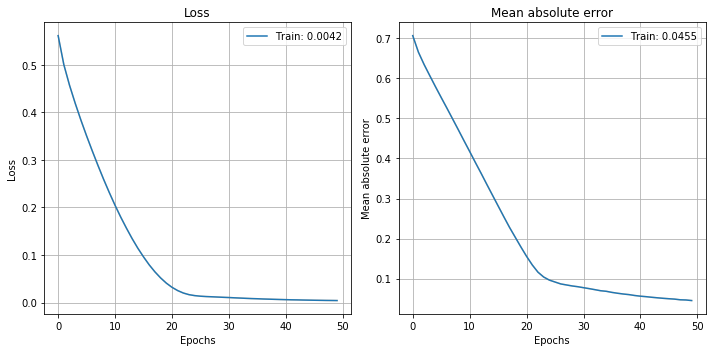

In [22]:
model.compile(loss= 'mean_squared_error', optimizer = 'rmsprop', metrics=[metrics.mae])
history = model.fit(X_train, Y_train, epochs=50, verbose=2).history
plot_history(history)
P_iwate = model.predict(X_test)

In [23]:
# オリジナルのスケールに戻す、タイムインデックスを付ける。
Y_train = scaler1.inverse_transform(Y_train)
Y_train = pd.DataFrame(Y_train)
Y_train.index = pd.to_datetime(iwate.iloc[3:185,0])

In [24]:
Y_test = scaler1.inverse_transform(Y_test)
Y_test = pd.DataFrame(Y_test)
Y_test.index = pd.to_datetime(iwate.iloc[185:,0])

In [25]:
P_iwate = scaler1.inverse_transform(P_iwate)
P_iwate = pd.DataFrame(P_iwate)
P_iwate.index=pd.to_datetime(iwate.iloc[185:,0])

In [26]:
P_iwate.index = TimeIndex2
Y_test.index = TimeIndex2
T_iwate = Y_test

# 鳥取

In [27]:
L = len(tottori)
Y = tottori.iloc[:, 4]  # 終値の列のみ抽出する。
Y = np.array(Y)  # numpy配列に変換する。
Y = Y.reshape(-1, 1)  # 行列に変換する。（配列の要素数行×1列）

In [28]:
X1 = Y[0:L-3, :]  # 予測対象日の3日前のデータ
X2 = Y[1:L-2, :]  # 予測対象日の2日前のデータ
X3 = Y[2:L-1, :]  # 予測対象日の前日データ
Y = Y[3:L, :]  # 予測対象日のデータ
X = np.concatenate([X1, X2, X3], axis=1)  # numpy配列を結合する。

In [29]:
scaler.fit(X)  # スケーリングに使用する最小／最大値を計算する。
X = scaler.transform(X)  # Xをを0～1の範囲にスケーリングする。

In [30]:
scaler1.fit(Y)  # スケーリングに使用する最小／最大値を計算する。
Y = scaler1.transform(Y)  # Yをを0～1の範囲にスケーリングする。

In [31]:
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))  # 3次元配列に変換する。

In [32]:
# train, testデータを定義
X_train = X[:182, :, :]
X_test = X[182:, :, :]
Y_train = Y[:182, :]
Y_test = Y[182:, :]

In [33]:
model = Sequential()
model.add(LSTM(10, activation = 'tanh', input_shape = (1,3), recurrent_activation= 'hard_sigmoid'))
model.add(Dense(1))

Epoch 1/50
 - 0s - loss: 0.3610 - mean_absolute_error: 0.5742
Epoch 2/50
 - 0s - loss: 0.3021 - mean_absolute_error: 0.5246
Epoch 3/50
 - 0s - loss: 0.2616 - mean_absolute_error: 0.4867
Epoch 4/50
 - 0s - loss: 0.2269 - mean_absolute_error: 0.4530
Epoch 5/50
 - 0s - loss: 0.1950 - mean_absolute_error: 0.4188
Epoch 6/50
 - 0s - loss: 0.1662 - mean_absolute_error: 0.3855
Epoch 7/50
 - 0s - loss: 0.1400 - mean_absolute_error: 0.3535
Epoch 8/50
 - 0s - loss: 0.1160 - mean_absolute_error: 0.3214
Epoch 9/50
 - 0s - loss: 0.0942 - mean_absolute_error: 0.2895
Epoch 10/50
 - 0s - loss: 0.0751 - mean_absolute_error: 0.2583
Epoch 11/50
 - 0s - loss: 0.0586 - mean_absolute_error: 0.2285
Epoch 12/50
 - 0s - loss: 0.0445 - mean_absolute_error: 0.1989
Epoch 13/50
 - 0s - loss: 0.0330 - mean_absolute_error: 0.1711
Epoch 14/50
 - 0s - loss: 0.0239 - mean_absolute_error: 0.1450
Epoch 15/50
 - 0s - loss: 0.0170 - mean_absolute_error: 0.1202
Epoch 16/50
 - 0s - loss: 0.0121 - mean_absolute_error: 0.0984
E

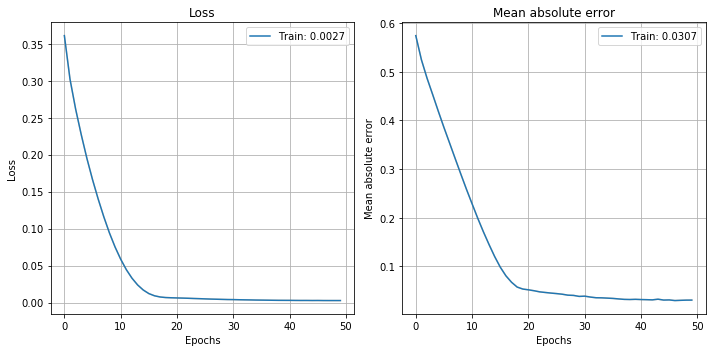

In [34]:
model.compile(loss= 'mean_squared_error', optimizer = 'rmsprop', metrics=[metrics.mae])
history = model.fit(X_train, Y_train, epochs=50, verbose=2).history
plot_history(history)
P_tottori = model.predict(X_test)

In [35]:
# オリジナルのスケールに戻す、タイムインデックスを付ける。
Y_train = scaler1.inverse_transform(Y_train)
Y_train = pd.DataFrame(Y_train)
Y_train.index = pd.to_datetime(tottori.iloc[3:185,0])

In [36]:
Y_test = scaler1.inverse_transform(Y_test)
Y_test = pd.DataFrame(Y_test)
Y_test.index = pd.to_datetime(tottori.iloc[185:,0])

In [37]:
P_tottori = scaler1.inverse_transform(P_tottori)
P_tottori = pd.DataFrame(P_tottori)
P_tottori.index=pd.to_datetime(tottori.iloc[185:,0])

In [38]:
P_tottori.index = TimeIndex2
Y_test.index = TimeIndex2
T_tottori = Y_test

# 秋田

In [39]:
L = len(akita)
Y = akita.iloc[:, 4]  # 終値の列のみ抽出する。
Y = np.array(Y)  # numpy配列に変換する。
Y = Y.reshape(-1, 1)  # 行列に変換する。（配列の要素数行×1列）

In [40]:
X1 = Y[0:L-3, :]  # 予測対象日の3日前のデータ
X2 = Y[1:L-2, :]  # 予測対象日の2日前のデータ
X3 = Y[2:L-1, :]  # 予測対象日の前日データ
Y = Y[3:L, :]  # 予測対象日のデータ
X = np.concatenate([X1, X2, X3], axis=1)  # numpy配列を結合する。

In [41]:
scaler.fit(X)  # スケーリングに使用する最小／最大値を計算する。
X = scaler.transform(X)  # Xをを0～1の範囲にスケーリングする。

In [42]:
scaler1.fit(Y)  # スケーリングに使用する最小／最大値を計算する。
Y = scaler1.transform(Y)  # Yをを0～1の範囲にスケーリングする。

In [43]:
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))  # 3次元配列に変換する。

In [44]:
# train, testデータを定義
X_train = X[:182, :, :]
X_test = X[182:, :, :]
Y_train = Y[:182, :]
Y_test = Y[182:, :]

In [45]:
model = Sequential()
model.add(LSTM(10, activation = 'tanh', input_shape = (1,3), recurrent_activation= 'hard_sigmoid'))
model.add(Dense(1))

Epoch 1/50
 - 0s - loss: 0.2830 - mean_absolute_error: 0.4948
Epoch 2/50
 - 0s - loss: 0.2296 - mean_absolute_error: 0.4439
Epoch 3/50
 - 0s - loss: 0.1939 - mean_absolute_error: 0.4065
Epoch 4/50
 - 0s - loss: 0.1639 - mean_absolute_error: 0.3727
Epoch 5/50
 - 0s - loss: 0.1377 - mean_absolute_error: 0.3407
Epoch 6/50
 - 0s - loss: 0.1139 - mean_absolute_error: 0.3091
Epoch 7/50
 - 0s - loss: 0.0928 - mean_absolute_error: 0.2786
Epoch 8/50
 - 0s - loss: 0.0742 - mean_absolute_error: 0.2492
Epoch 9/50
 - 0s - loss: 0.0580 - mean_absolute_error: 0.2205
Epoch 10/50
 - 0s - loss: 0.0442 - mean_absolute_error: 0.1924
Epoch 11/50
 - 0s - loss: 0.0330 - mean_absolute_error: 0.1661
Epoch 12/50
 - 0s - loss: 0.0244 - mean_absolute_error: 0.1421
Epoch 13/50
 - 0s - loss: 0.0179 - mean_absolute_error: 0.1209
Epoch 14/50
 - 0s - loss: 0.0134 - mean_absolute_error: 0.1018
Epoch 15/50
 - 0s - loss: 0.0108 - mean_absolute_error: 0.0872
Epoch 16/50
 - 0s - loss: 0.0093 - mean_absolute_error: 0.0765
E

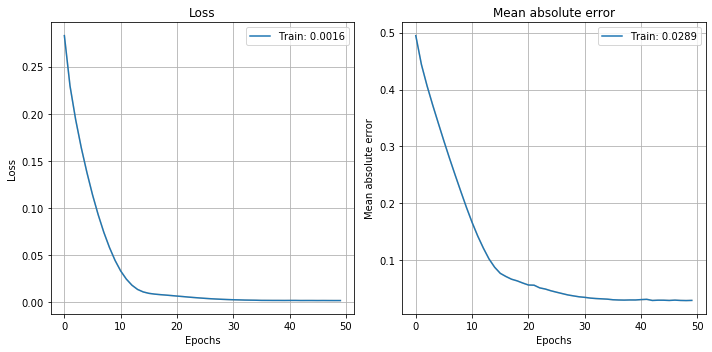

In [46]:
model.compile(loss= 'mean_squared_error', optimizer = 'rmsprop', metrics=[metrics.mae])
history = model.fit(X_train, Y_train, epochs=50, verbose=2).history
plot_history(history)
P_akita = model.predict(X_test)

In [47]:
# オリジナルのスケールに戻す、タイムインデックスを付ける。
Y_train = scaler1.inverse_transform(Y_train)
Y_train = pd.DataFrame(Y_train)
Y_train.index = pd.to_datetime(akita.iloc[3:185,0])

In [48]:
Y_test = scaler1.inverse_transform(Y_test)
Y_test = pd.DataFrame(Y_test)
Y_test.index = pd.to_datetime(akita.iloc[185:,0])

In [49]:
P_akita = scaler1.inverse_transform(P_akita)
P_akita = pd.DataFrame(P_akita)
P_akita.index=pd.to_datetime(akita.iloc[185:,0])

In [50]:
P_akita.index = TimeIndex2
Y_test.index = TimeIndex2
T_akita = Y_test

# 山形

In [51]:
L = len(yamagata)
Y = yamagata.iloc[:, 4]  # 終値の列のみ抽出する。
Y = np.array(Y)  # numpy配列に変換する。
Y = Y.reshape(-1, 1)  # 行列に変換する。（配列の要素数行×1列）

In [52]:
X1 = Y[0:L-3, :]  # 予測対象日の3日前のデータ
X2 = Y[1:L-2, :]  # 予測対象日の2日前のデータ
X3 = Y[2:L-1, :]  # 予測対象日の前日データ
Y = Y[3:L, :]  # 予測対象日のデータ
X = np.concatenate([X1, X2, X3], axis=1)  # numpy配列を結合する。

In [53]:
scaler.fit(X)  # スケーリングに使用する最小／最大値を計算する。
X = scaler.transform(X)  # Xをを0～1の範囲にスケーリングする。

In [54]:
scaler1.fit(Y)  # スケーリングに使用する最小／最大値を計算する。
Y = scaler1.transform(Y)  # Yをを0～1の範囲にスケーリングする。

In [55]:
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))  # 3次元配列に変換する。

In [56]:
# train, testデータを定義
X_train = X[:182, :, :]
X_test = X[182:, :, :]
Y_train = Y[:182, :]
Y_test = Y[182:, :]

In [57]:
model = Sequential()
model.add(LSTM(10, activation = 'tanh', input_shape = (1,3), recurrent_activation= 'hard_sigmoid'))
model.add(Dense(1))

Epoch 1/50
 - 0s - loss: 0.3667 - mean_absolute_error: 0.5715
Epoch 2/50
 - 0s - loss: 0.3145 - mean_absolute_error: 0.5272
Epoch 3/50
 - 0s - loss: 0.2782 - mean_absolute_error: 0.4947
Epoch 4/50
 - 0s - loss: 0.2463 - mean_absolute_error: 0.4644
Epoch 5/50
 - 0s - loss: 0.2170 - mean_absolute_error: 0.4353
Epoch 6/50
 - 0s - loss: 0.1898 - mean_absolute_error: 0.4065
Epoch 7/50
 - 0s - loss: 0.1644 - mean_absolute_error: 0.3777
Epoch 8/50
 - 0s - loss: 0.1409 - mean_absolute_error: 0.3493
Epoch 9/50
 - 0s - loss: 0.1191 - mean_absolute_error: 0.3205
Epoch 10/50
 - 0s - loss: 0.0992 - mean_absolute_error: 0.2921
Epoch 11/50
 - 0s - loss: 0.0812 - mean_absolute_error: 0.2637
Epoch 12/50
 - 0s - loss: 0.0652 - mean_absolute_error: 0.2360
Epoch 13/50
 - 0s - loss: 0.0511 - mean_absolute_error: 0.2085
Epoch 14/50
 - 0s - loss: 0.0395 - mean_absolute_error: 0.1817
Epoch 15/50
 - 0s - loss: 0.0300 - mean_absolute_error: 0.1568
Epoch 16/50
 - 0s - loss: 0.0222 - mean_absolute_error: 0.1340
E

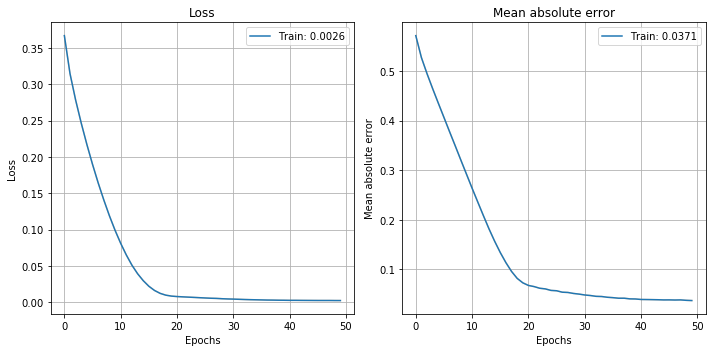

In [58]:
model.compile(loss= 'mean_squared_error', optimizer = 'rmsprop', metrics=[metrics.mae])
history = model.fit(X_train, Y_train, epochs=50, verbose=2).history
plot_history(history)
P_yamagata = model.predict(X_test)

In [59]:
# オリジナルのスケールに戻す、タイムインデックスを付ける。
Y_train = scaler1.inverse_transform(Y_train)
Y_train = pd.DataFrame(Y_train)
Y_train.index = pd.to_datetime(yamagata.iloc[3:185,0])

In [60]:
Y_test = scaler1.inverse_transform(Y_test)
Y_test = pd.DataFrame(Y_test)
Y_test.index = pd.to_datetime(yamagata.iloc[185:,0])

In [61]:
P_yamagata = scaler1.inverse_transform(P_yamagata)
P_yamagata = pd.DataFrame(P_yamagata)
P_yamagata.index=pd.to_datetime(yamagata.iloc[185:,0])

In [62]:
P_yamagata.index = TimeIndex2
Y_test.index = TimeIndex2
T_yamagata = Y_test

# 愛媛

In [63]:
L = len(ehime)
Y = ehime.iloc[:, 4]  # 終値の列のみ抽出する。
Y = np.array(Y)  # numpy配列に変換する。
Y = Y.reshape(-1, 1)  # 行列に変換する。（配列の要素数行×1列）

In [64]:
X1 = Y[0:L-3, :]  # 予測対象日の3日前のデータ
X2 = Y[1:L-2, :]  # 予測対象日の2日前のデータ
X3 = Y[2:L-1, :]  # 予測対象日の前日データ
Y = Y[3:L, :]  # 予測対象日のデータ
X = np.concatenate([X1, X2, X3], axis=1)  # numpy配列を結合する。

In [65]:
scaler = MinMaxScaler()  # データを0～1の範囲にスケールするための関数。
scaler.fit(X)  # スケーリングに使用する最小／最大値を計算する。
X = scaler.transform(X)  # Xをを0～1の範囲にスケーリングする。

In [66]:
scaler1.fit(Y)  # スケーリングに使用する最小／最大値を計算する。
Y = scaler1.transform(Y)  # Yをを0～1の範囲にスケーリングする。

In [67]:
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))  # 3次元配列に変換する。

In [68]:
# train, testデータを定義
X_train = X[:182, :, :]
X_test = X[182:, :, :]
Y_train = Y[:182, :]
Y_test = Y[182:, :]

In [69]:
model = Sequential()
model.add(LSTM(10, activation = 'tanh', input_shape = (1,3), recurrent_activation= 'hard_sigmoid'))
model.add(Dense(1))

Epoch 1/50
 - 0s - loss: 0.4311 - mean_absolute_error: 0.6226
Epoch 2/50
 - 0s - loss: 0.3789 - mean_absolute_error: 0.5819
Epoch 3/50
 - 0s - loss: 0.3421 - mean_absolute_error: 0.5512
Epoch 4/50
 - 0s - loss: 0.3100 - mean_absolute_error: 0.5236
Epoch 5/50
 - 0s - loss: 0.2803 - mean_absolute_error: 0.4967
Epoch 6/50
 - 0s - loss: 0.2521 - mean_absolute_error: 0.4696
Epoch 7/50
 - 0s - loss: 0.2251 - mean_absolute_error: 0.4423
Epoch 8/50
 - 0s - loss: 0.1995 - mean_absolute_error: 0.4155
Epoch 9/50
 - 0s - loss: 0.1754 - mean_absolute_error: 0.3880
Epoch 10/50
 - 0s - loss: 0.1529 - mean_absolute_error: 0.3611
Epoch 11/50
 - 0s - loss: 0.1319 - mean_absolute_error: 0.3344
Epoch 12/50
 - 0s - loss: 0.1126 - mean_absolute_error: 0.3082
Epoch 13/50
 - 0s - loss: 0.0944 - mean_absolute_error: 0.2816
Epoch 14/50
 - 0s - loss: 0.0783 - mean_absolute_error: 0.2555
Epoch 15/50
 - 0s - loss: 0.0639 - mean_absolute_error: 0.2294
Epoch 16/50
 - 0s - loss: 0.0514 - mean_absolute_error: 0.2041
E

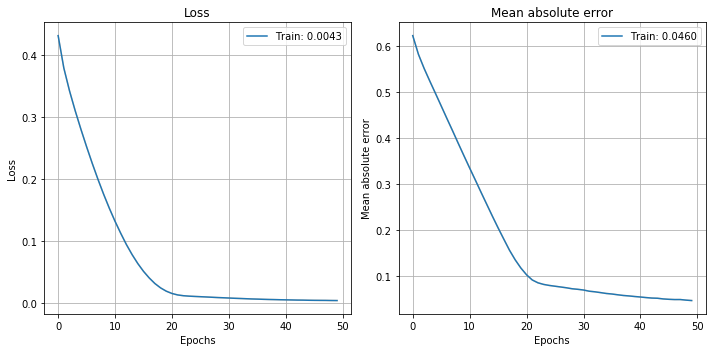

In [70]:
model.compile(loss= 'mean_squared_error', optimizer = 'rmsprop', metrics=[metrics.mae])
history = model.fit(X_train, Y_train, epochs=50, verbose=2).history
plot_history(history)
P_ehime = model.predict(X_test)

In [71]:
# オリジナルのスケールに戻す、タイムインデックスを付ける。
Y_train = scaler1.inverse_transform(Y_train)
Y_train = pd.DataFrame(Y_train)
Y_train.index = pd.to_datetime(ehime.iloc[3:185,0])

In [72]:
Y_test = scaler1.inverse_transform(Y_test)
Y_test = pd.DataFrame(Y_test)
Y_test.index = pd.to_datetime(ehime.iloc[185:,0])

In [73]:
P_ehime = scaler1.inverse_transform(P_ehime)
P_ehime = pd.DataFrame(P_ehime)
P_ehime.index=pd.to_datetime(ehime.iloc[185:,0])

In [74]:
P_ehime.index = TimeIndex2
Y_test.index = TimeIndex2
T_ehime = Y_test

# plot

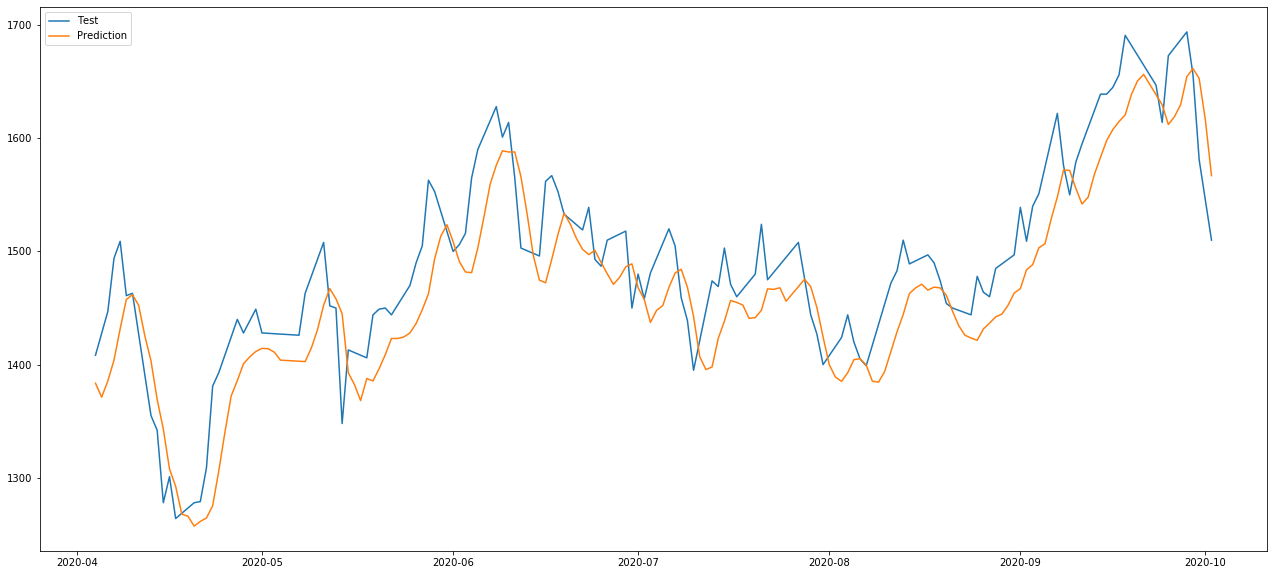

In [75]:
plt.figure(figsize=(22,10))
plt.plot(T_akita, label = 'Test')
plt.plot(P_akita, label = 'Prediction')
plt.legend(loc='best')
plt.show()

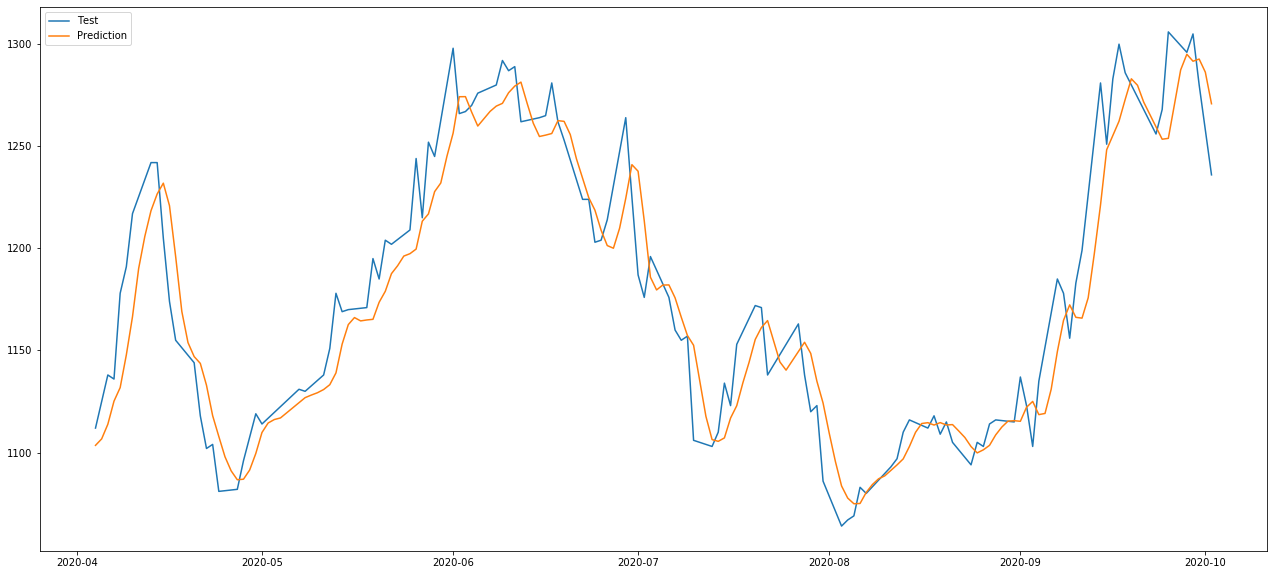

In [76]:
plt.figure(figsize=(22,10))
plt.plot(T_tottori, label = 'Test')
plt.plot(P_tottori, label = 'Prediction')
plt.legend(loc='best')
plt.show()

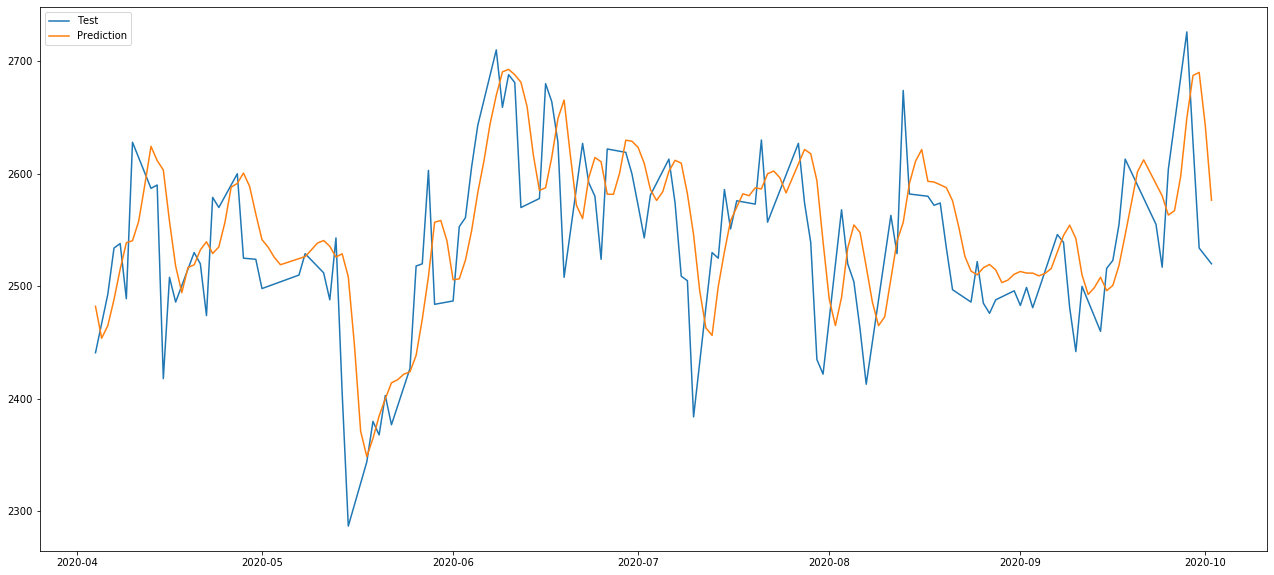

In [77]:
plt.figure(figsize=(22,10))
plt.plot(T_iwate, label = 'Test')
plt.plot(P_iwate, label = 'Prediction')
plt.legend(loc='best')
plt.show()

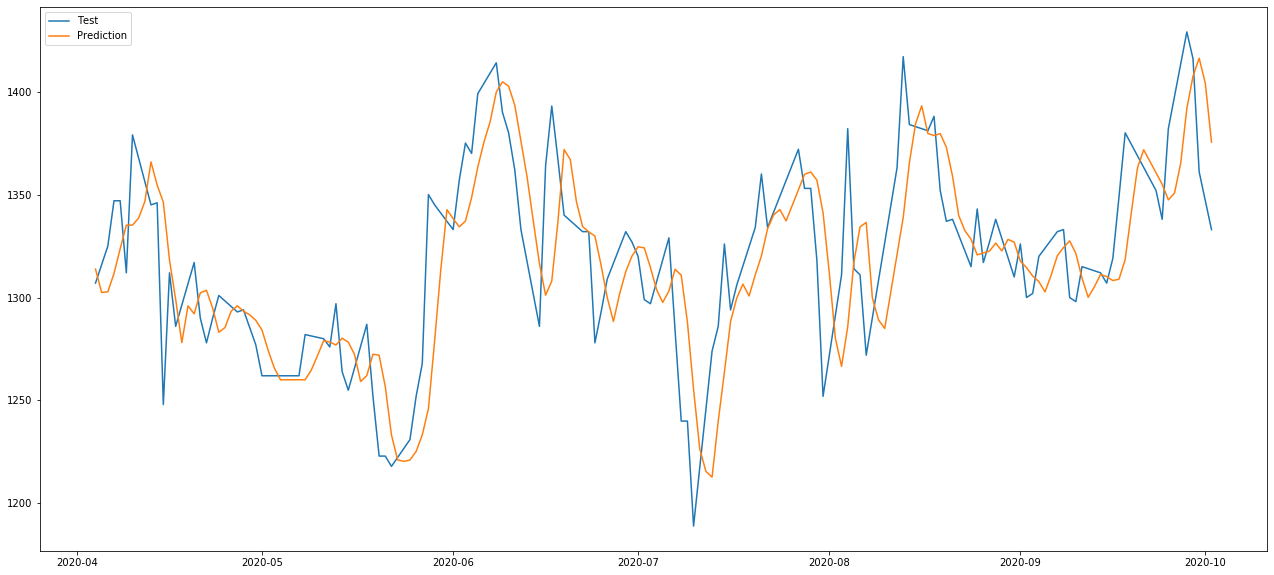

In [78]:
plt.figure(figsize=(22,10))
plt.plot(T_yamagata, label = 'Test')
plt.plot(P_yamagata, label = 'Prediction')
plt.legend(loc='best')
plt.show()

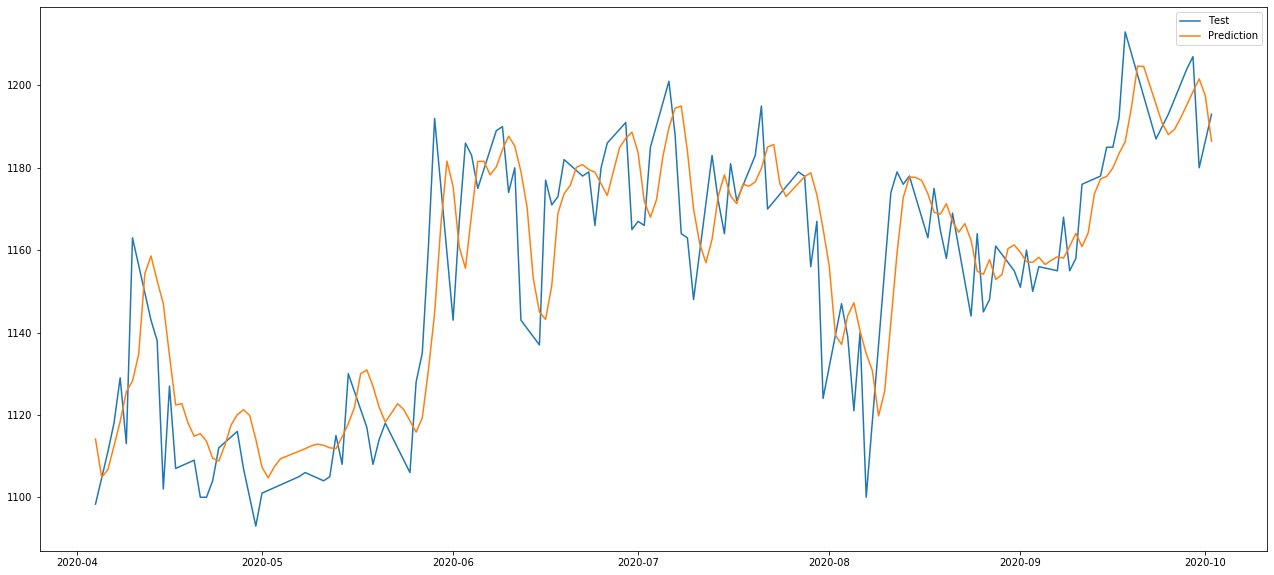

In [79]:
plt.figure(figsize=(22,10))
plt.plot(T_ehime, label = 'Test')
plt.plot(P_ehime, label = 'Prediction')
plt.legend(loc='best')
plt.show()

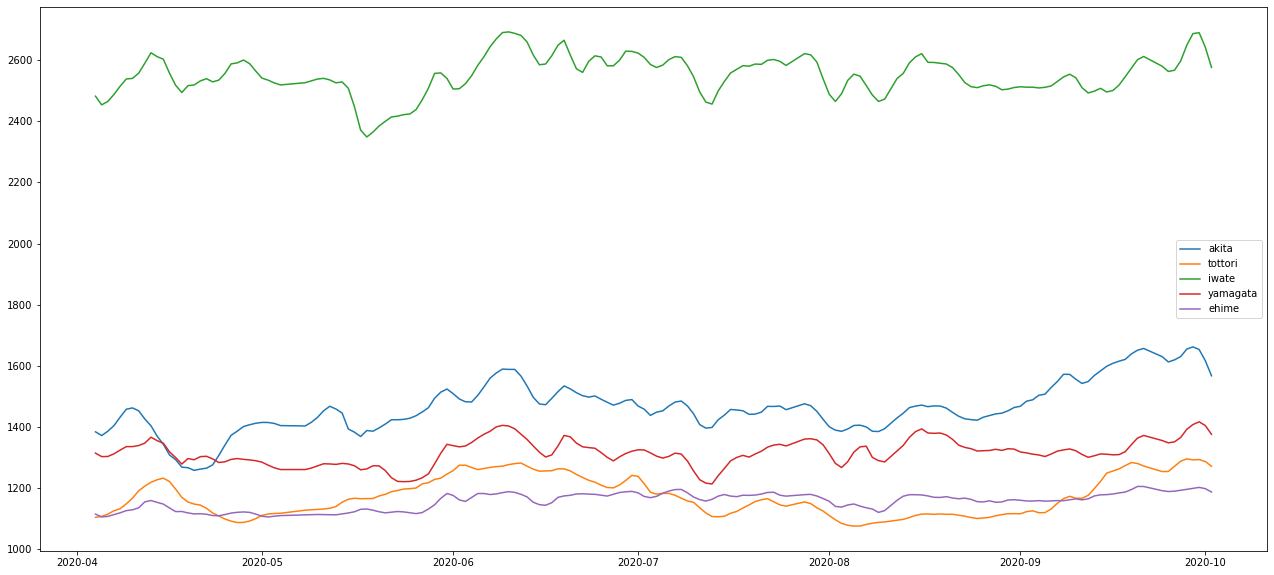

In [80]:
plt.figure(figsize=(22,10))
plt.plot(P_akita, label = 'akita')
plt.plot(P_tottori, label = 'tottori')
plt.plot(P_iwate, label = 'iwate')
plt.plot(P_yamagata, label = 'yamagata')
plt.plot(P_ehime, label = 'ehime')
plt.legend(loc='best')
plt.show()

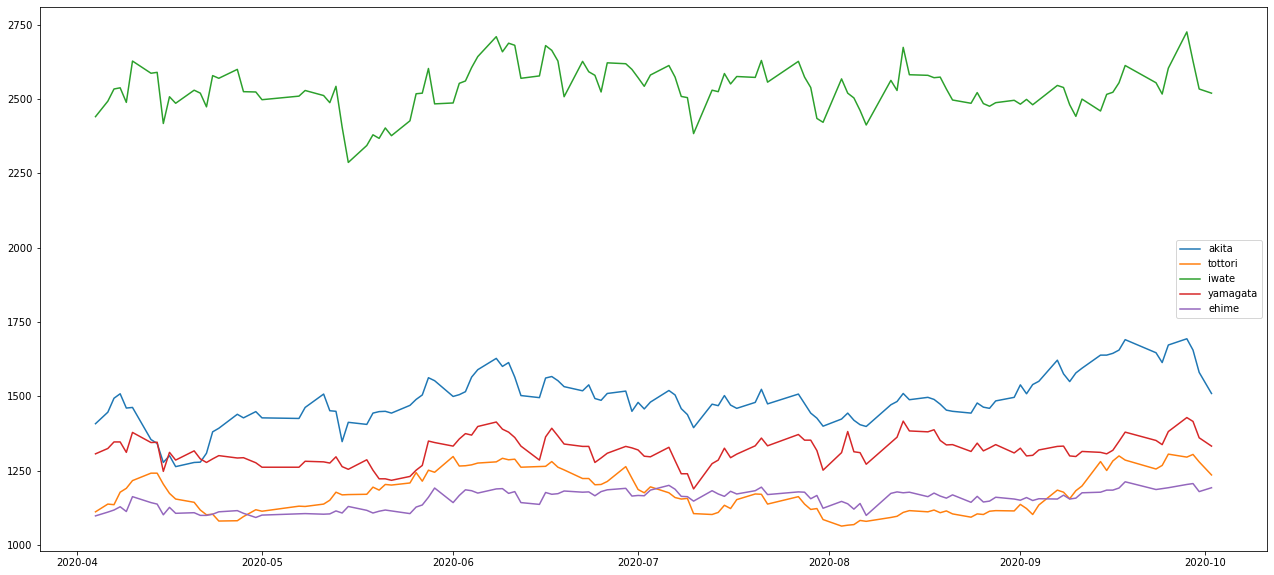

In [81]:
plt.figure(figsize=(22,10))
plt.plot(T_akita, label = 'akita')
plt.plot(T_tottori, label = 'tottori')
plt.plot(T_iwate, label = 'iwate')
plt.plot(T_yamagata, label = 'yamagata')
plt.plot(T_ehime, label = 'ehime')
plt.legend(loc='best')
plt.show()

In [82]:
P_akita['diff']=P_akita.diff()
P_tottori['diff']=P_tottori.diff()
P_iwate['diff']=P_iwate.diff()
P_yamagata['diff']=P_yamagata.diff()
P_ehime['diff']=P_ehime.diff()

In [83]:
T_akita['diff'] = T_akita.diff()
T_tottori['diff'] = T_tottori.diff()
T_iwate['diff'] = T_iwate.diff()
T_yamagata['diff'] = T_yamagata.diff()
T_ehime['diff'] = T_ehime.diff()

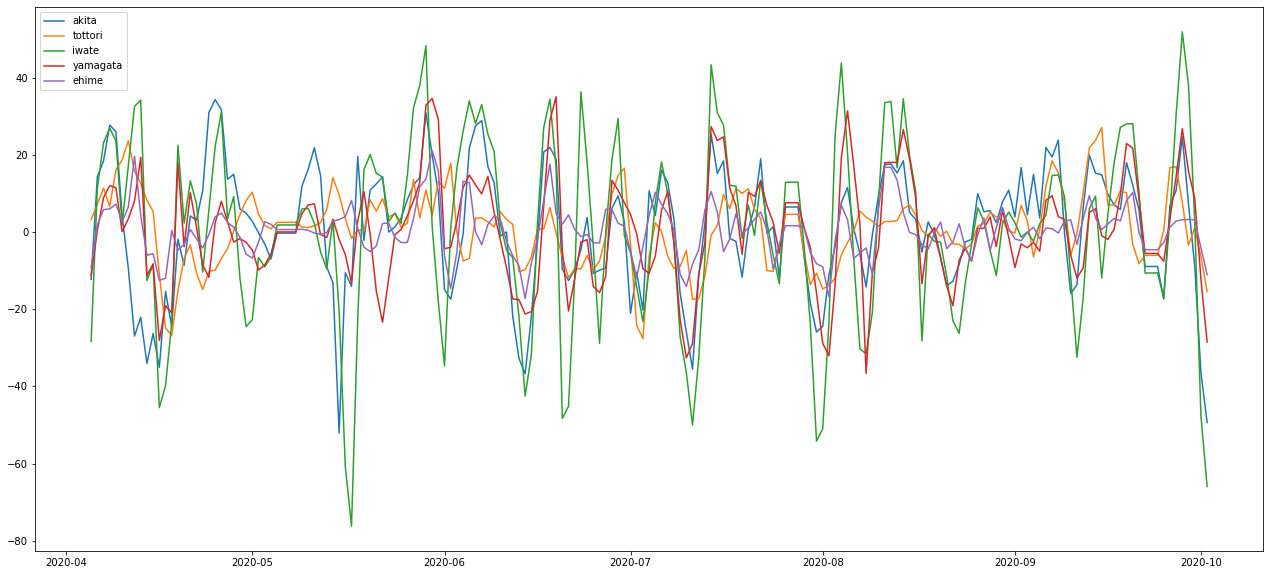

In [84]:
plt.figure(figsize=(22,10))
plt.plot(P_akita['diff'], label = 'akita')
plt.plot(P_tottori['diff'], label = 'tottori')
plt.plot(P_iwate['diff'], label = 'iwate')
plt.plot(P_yamagata['diff'], label = 'yamagata')
plt.plot(P_ehime['diff'], label = 'ehime')
plt.savefig('P_worst5.png')
plt.legend(loc='best')
plt.show()

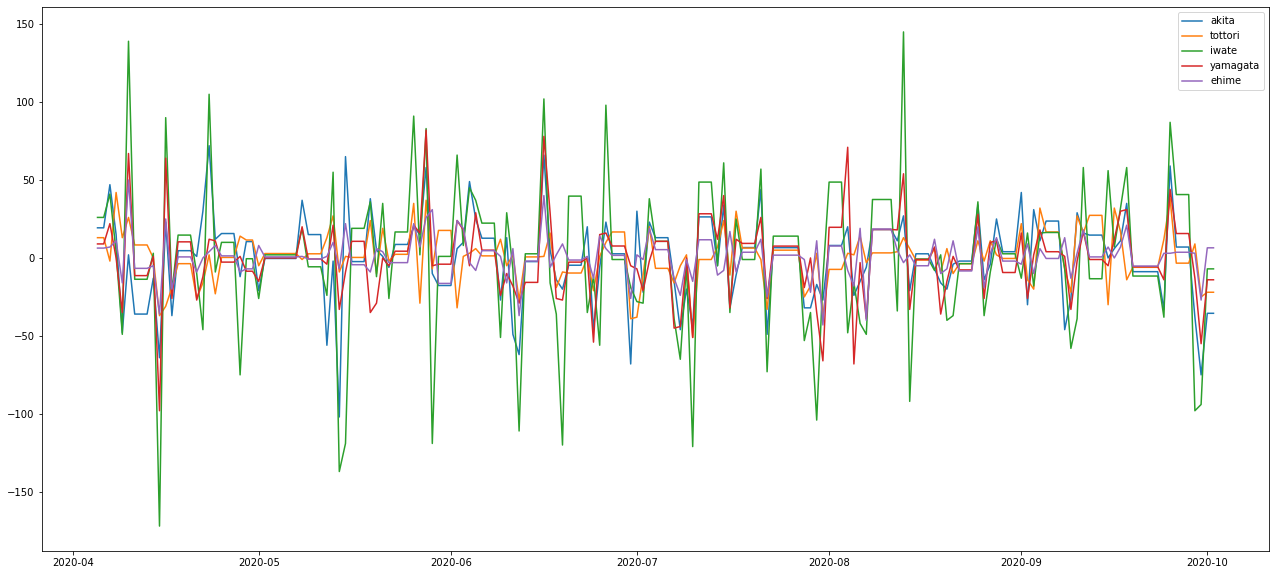

In [85]:
plt.figure(figsize=(22,10))
plt.plot(T_akita['diff'], label = 'akita')
plt.plot(T_tottori['diff'], label = 'tottori')
plt.plot(T_iwate['diff'], label = 'iwate')
plt.plot(T_yamagata['diff'], label = 'yamagata')
plt.plot(T_ehime['diff'], label = 'ehime')
plt.savefig('worst5.png')
plt.legend(loc='best')
plt.show()

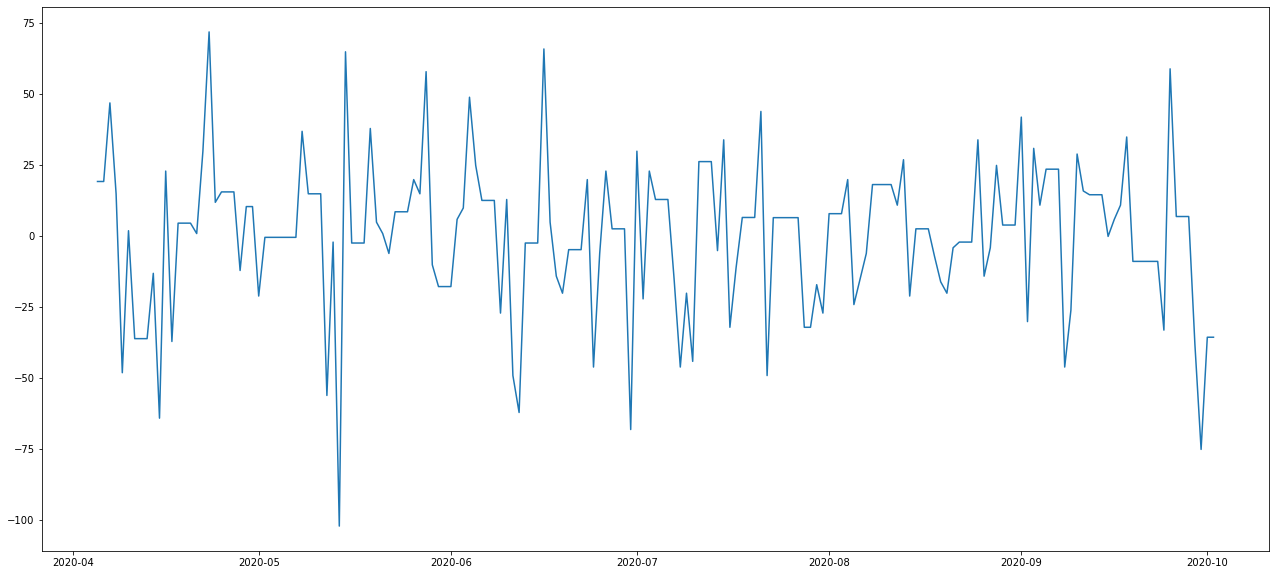

In [86]:
plt.plot(T_akita['diff'], label = 'akita')
plt.savefig('akita.png')

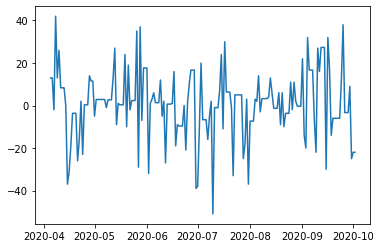

In [87]:
plt.plot(T_tottori['diff'], label = 'tottori')
plt.savefig('tottori.png')

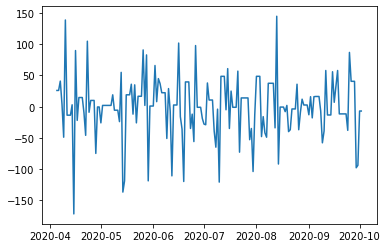

In [88]:
plt.plot(T_iwate['diff'], label = 'iwate')
plt.savefig('iwate.png')

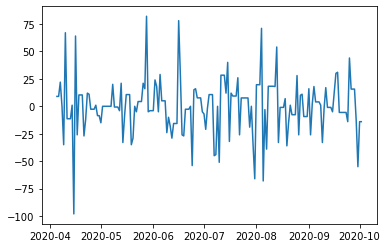

In [89]:
plt.plot(T_yamagata['diff'], label = 'yamagata')
plt.savefig('yamagata.png')

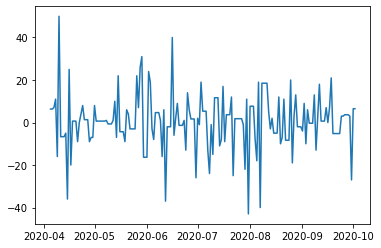

In [90]:
plt.plot(T_ehime['diff'], label = 'ehime')
plt.savefig('ehime.png')